# S-N-VAE Model Testing Framework (Cars3D)

In [1]:
import sys
from pathlib import Path

# Find project root by looking for .git or requirements.txt
current = Path.cwd()
while not any((current / marker).exists() for marker in ['.git', 'requirements.txt']):
    if current.parent == current:
        raise FileNotFoundError("Project root not found")
    current = current.parent

sys.path.append(str(current))
print(f"Added project root: {current}")

Added project root: /notebooks


# Hyperparameters

In [2]:
import torch

#### deterministic run ####
determinism_kwargs = {
    'seed':0,
    'use_cuda_det': True,
    'enforce_det':False,
    'cublas_workspace_config': None,
}

##### Model parameters #####
model_name = 's_n_vae_locatello'  # S-N-VAE model with Locatello architecture
model_decoder_output_dist = 'gaussian'  # Output distribution for RGB images

# Define latent factor topologies: elevation (R1) and azimuth (S1 - circular)
latent_factor_topologies = ['R1', 'S1']  # 2 factors total

use_torch_compile = False  # Use torch.compile for model compilation

#### Training parameters ####
train_step_unit = 'epoch'  # Unit for training steps ('epoch' or 'iteration')
num_train_steps = 10000

# train_step_unit = 'iteration'  # Unit for training steps ('epoch' or 'iteration')
# num_train_steps = int(9e3)  # Number of training steps 

learning_rate = 1e-4
batch_size = 64

#### losses ####
loss_name = 'beta_s_n_vae'      # S-N-VAE Beta loss
loss_kwargs_cars3d = {
    'beta': 10,
    'latent_factor_topologies': latent_factor_topologies,
    'rec_dist': 'gaussian',  # Reconstruction distribution for RGB images
    'log_kl_components': True,
#     'schedulers_kwargs':[
#     {
#         'name': 'linear',
#         'kwargs': {
#             'param_name': 'beta',
#             'initial_value': 0,
#             'final_value': 16,
#             'total_steps': 100000
#         }
#     }
# ]
}

#### device parameters ####
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f"Using GPU")
else:
    print("Using CPU")

### Checkpoint parameters ###
return_chkpt = False
chkpt_every_n_steps = 2400

# chkpt_save_path = 'checkpoints/tests/test-epoch-1.pt'
chkpt_save_path = None

chkpt_save_dir = None
# chkpt_save_dir = 'checkpoints/tests_s_n_vae'

chkpt_save_master_dir = None
chkpt_viz = False

Using GPU


# Reproducibility

In [3]:
if determinism_kwargs is not None:
    # MUST Be set before importing any other modules
    # to ensure reproducibility across all libraries
    from utils.reproducibility import set_deterministic_run, get_deterministic_dataloader
    set_deterministic_run(**determinism_kwargs)
    print(f"Set deterministic run with kwargs: {determinism_kwargs}")

Set deterministic run with kwargs: {'seed': 0, 'use_cuda_det': True, 'enforce_det': False, 'cublas_workspace_config': None}


# Imports

In [4]:
import torch
import numpy as np
import torch.utils
import matplotlib.pyplot as plt
import torch.optim as optim

import utils.visualize
from trainers import UnsupervisedTrainer
import losses
import vae_models
from datasets import get_dataset
from utils.io import find_optimal_num_workers
from metrics.utils import MetricAggregator

## Setup Model, Loss, and Optimizer

In [5]:
def setup_components(dataset, loss_kwargs, latent_factor_topologies):
    """Instantiates model, loss function, and optimizer based on config."""
    img_size = dataset[0][0].shape
    n_data = len(dataset)
    
    # Instantiate S-N-VAE Model
    model = vae_models.select(name=model_name, 
                              img_size=img_size, 
                              latent_factor_topologies=latent_factor_topologies,
                              decoder_output_dist=model_decoder_output_dist
                              ).to(device)

    # Instantiate S-N-VAE Loss
    loss_fn = losses.select(loss_name, **loss_kwargs)

    # Instantiate Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"--- Setup for {dataset.__class__.__name__} --- ")
    print(f"Model: {model.model_name}")
    print(f"Latent factor topologies: {latent_factor_topologies}")
    print(f"Loss: {loss_fn.name} (rec_dist={loss_kwargs['rec_dist']}), kwargs={loss_kwargs}")
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print(f"Learning rate: {learning_rate}")

    return model, loss_fn, optimizer

# Cars3D

In [6]:
# Load Cars3D
Cars3D = get_dataset('cars3d')

# Use only one car type (object_type=0) and vary elevation and azimuth
cars3d_dataset = Cars3D(selected_factors=['elevation', 'azimuth'], 
                        not_selected_factors_index_value={'object_type': 0})

# num_workers_cars3d = find_optimal_num_workers(cars3d_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_cars3d = 7

if determinism_kwargs is not None:
    cars3d_dataloader = get_deterministic_dataloader(dataset=cars3d_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_cars3d,
                                                   seed=determinism_kwargs['seed'],
                                                   pin_memory=True)
else:
    cars3d_dataloader = torch.utils.data.DataLoader(cars3d_dataset, 
                                                    batch_size=batch_size, 
                                                    num_workers=num_workers_cars3d, 
                                                    shuffle=True, 
                                                    pin_memory=True)

print(f"Loaded Cars3D dataset with {len(cars3d_dataset)} samples.")
print(f"Factor names: {cars3d_dataset.factor_names}")
print(f"Selected factors: {cars3d_dataset.selected_factors}")
print(f"Fixed factors: {cars3d_dataset.not_selected_factors_index_value}")

Loaded Cars3D dataset with 96 samples.
Factor names: ('elevation', 'azimuth', 'object_type')
Selected factors: ['elevation', 'azimuth']
Fixed factors: {'object_type': 0}


## Train

In [7]:
print("\n===== Training S-N-VAE on Cars3D =====")
model_cars3d, loss_fn_cars3d, optimizer_cars3d = setup_components(cars3d_dataset, 
                                                                  loss_kwargs_cars3d,
                                                                  latent_factor_topologies
                                                                  )
trainer_cars3d = UnsupervisedTrainer(model=model_cars3d,
                                    loss=loss_fn_cars3d,
                                    optimizer=optimizer_cars3d,
                                    lr_scheduler=None,
                                    determinism_kwargs=determinism_kwargs,
                                    use_torch_compile=use_torch_compile,
                                    return_logs=True,
                                    return_chkpt=return_chkpt,
                                    chkpt_save_path=chkpt_save_path,
                                    chkpt_save_dir=chkpt_save_dir,
                                    chkpt_every_n_steps=chkpt_every_n_steps,
                                    chkpt_viz=chkpt_viz
                                    )

trainer_cars3d.train(max_steps=num_train_steps, step_unit=train_step_unit, dataloader=cars3d_dataloader)


===== Training S-N-VAE on Cars3D =====
--- Setup for Cars3D --- 
Model: s_n_vae_locatello
Latent factor topologies: ['R1', 'S1']
Loss: beta_s_n_vae (rec_dist=gaussian), kwargs={'beta': 10, 'latent_factor_topologies': ['R1', 'S1'], 'rec_dist': 'gaussian', 'log_kl_components': True}
Optimizer: Adam
Learning rate: 0.0001
--- Setup for Cars3D --- 
Model: s_n_vae_locatello
Latent factor topologies: ['R1', 'S1']
Loss: beta_s_n_vae (rec_dist=gaussian), kwargs={'beta': 10, 'latent_factor_topologies': ['R1', 'S1'], 'rec_dist': 'gaussian', 'log_kl_components': True}
Optimizer: Adam
Learning rate: 0.0001


Training for 20000 iter, 10000.00 epochs: 100%|██████████| 20000/20000 [04:57<00:00, 67.33it/s, epoch=10000.00/10000.00, iter=20000/20000, kl_loss=5.09, kl_loss_0_R1=2.41, kl_loss_1_S1=2.67, loss=87.3, rec_loss=36.4]



{'logs': {'train_losses_log': [{'loss': 3955.7038580322264,
    'rec_loss': 3923.7534002685547,
    'kl_loss': 3.1950468546152115,
    'kl_loss_0_R1': 2.493205687776208,
    'kl_loss_1_S1': 0.7018411749601364,
    'iter': 200,
    'epoch': 100.0},
   {'loss': 781.2287777709961,
    'rec_loss': 741.1121365356445,
    'kl_loss': 4.011664023399353,
    'kl_loss_0_R1': 2.8736509954929352,
    'kl_loss_1_S1': 1.138013021349907,
    'iter': 400,
    'epoch': 200.0},
   {'loss': 540.586785736084,
    'rec_loss': 502.5346803283691,
    'kl_loss': 3.805210579633713,
    'kl_loss_0_R1': 2.5444581258296965,
    'kl_loss_1_S1': 1.2607524478435517,
    'iter': 600,
    'epoch': 300.0},
   {'loss': 411.58138229370115,
    'rec_loss': 374.11256057739257,
    'kl_loss': 3.7468820977211,
    'kl_loss_0_R1': 2.3135475635528566,
    'kl_loss_1_S1': 1.4333345383405685,
    'iter': 800,
    'epoch': 400.0},
   {'loss': 342.44653823852536,
    'rec_loss': 305.3392179870605,
    'kl_loss': 3.710732092857361,

In [8]:
print("\n===== Visualizing Cars3D Results =====")
visualizer_cars3d = utils.visualize.SNVAEVisualizer(vae_model=model_cars3d, dataset=cars3d_dataset)


===== Visualizing Cars3D Results =====


## Visualization

### Reconstructions

Plotting random reconstructions...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

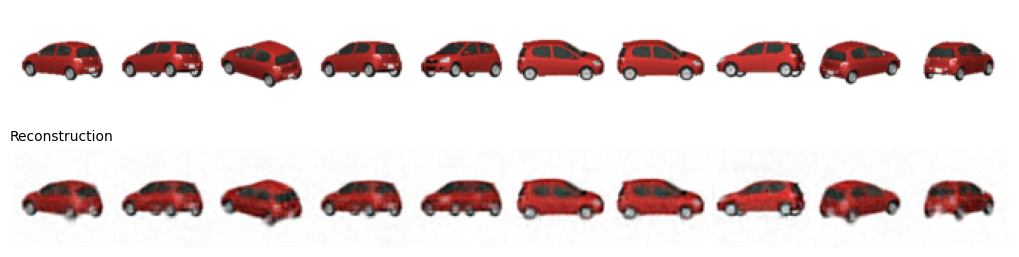

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Plotting reconstructions from specific indices...


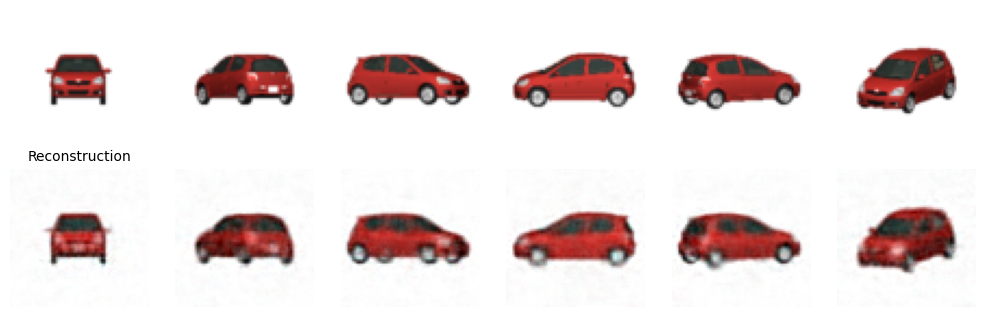

In [9]:
print("Plotting random reconstructions...")
visualizer_cars3d.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_cars3d = [0, 10, 20, 30, 40, 50]  # Example indices
visualizer_cars3d.plot_reconstructions_sub_dataset(indices_cars3d, mode='mean')
plt.show()

### Latent traversal

Plotting latent traversals...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

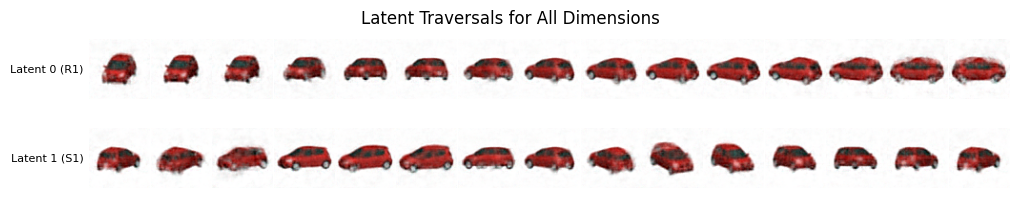

In [10]:
print("Plotting latent traversals...")
visualizer_cars3d.plot_all_latent_traversals(num_samples=15,
                                             r1_max_traversal_type='probability',
                                             r1_max_traversal=0.95,
                                             s1_max_traversal_type='fraction',
                                             s1_max_traversal=1.0,
                                             use_ref_img=True
                                             )
plt.show()

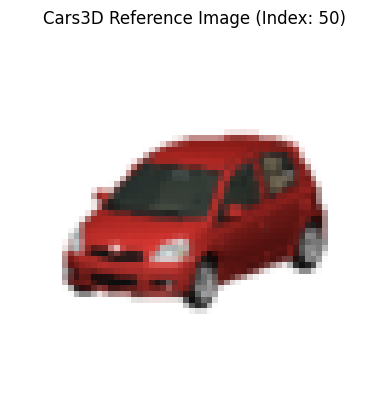

In [11]:
# Select a reference image index for Cars3D
ref_img_idx_cars3d = 50  # Example index (Cars3D has fewer samples than dSprites)
ref_img_cars3d = cars3d_dataset[ref_img_idx_cars3d][0]

# Plot the reference image (RGB - no need for grayscale colormap)
plt.imshow(ref_img_cars3d.permute(1, 2, 0).cpu().numpy())
plt.title(f"Cars3D Reference Image (Index: {ref_img_idx_cars3d})")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Plotting single latent traversal for dimension 0 (elevation)...


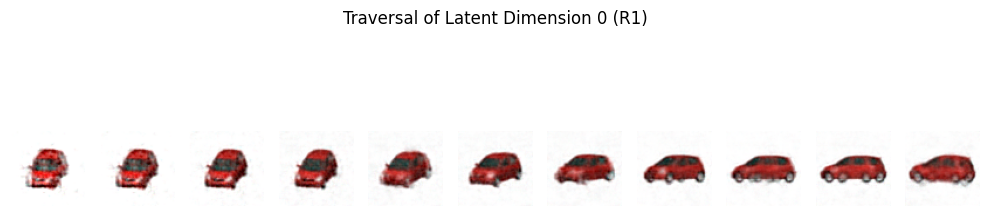

In [12]:
# Single latent traversal based on the reference image
latent_factor_idx_cars3d = 0  # Index of the latent dimension to traverse (0=elevation, 1=azimuth)
print(f"Plotting single latent traversal for dimension {latent_factor_idx_cars3d} (elevation)...")
visualizer_cars3d.plot_single_latent_traversal(latent_factor_idx_cars3d, 
                                               ref_img=ref_img_cars3d, 
                                               num_samples=11,
                                               max_traversal_type='probability',
                                               max_traversal=0.95)
plt.show()

Plotting single latent traversal for dimension 1 (azimuth)...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

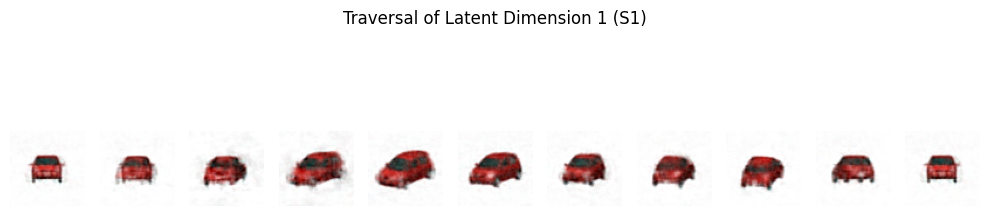

In [13]:
# Single latent traversal for azimuth (circular factor)
latent_factor_idx_cars3d = 1  # Index of the latent dimension to traverse (1=azimuth)
print(f"Plotting single latent traversal for dimension {latent_factor_idx_cars3d} (azimuth)...")
visualizer_cars3d.plot_single_latent_traversal(latent_factor_idx_cars3d, 
                                               ref_img=ref_img_cars3d, 
                                               num_samples=11,
                                               max_traversal_type='fraction',
                                               max_traversal=1.0)
plt.show()

Plotting all latent traversals based on reference image...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

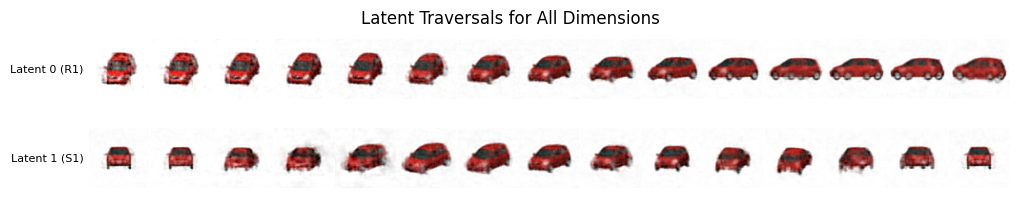

In [14]:
# All latent traversals based on the reference image
print("Plotting all latent traversals based on reference image...")
visualizer_cars3d.plot_all_latent_traversals(ref_img=ref_img_cars3d, 
                                             num_samples=15,
                                             r1_max_traversal_type='probability',
                                             r1_max_traversal=0.95,
                                             s1_max_traversal_type='fraction',
                                             s1_max_traversal=1.0
                                             )
plt.show()